# Optimising Hospital Locations for Malaria Treatment Accessibility in Ghana: A Comprehensive Methodology

Research Question
- How can spatial optimization techniques identify optimal hospital placement locations to improve accessibility for malaria treatment access?

In [1]:
!pip install osmnx

In [2]:
# 1. Initial Setup and Data Loading

import pandas as pd                       # For data manipulation and analysis
import geopandas as gpd                   # For handling geographic data and shapefiles
import numpy as np                        # For numerical computations
import rasterio                           # For reading and processing raster data (population, malaria)
from rasterio.features import rasterize
from rasterio.features import shapes
from shapely.geometry import shape
from shapely.geometry import Polygon
import networkx as nx                     # For road network analysis and shortest path calculations
import osmnx as ox                        # For downloading and processing OpenStreetMap road data
from scipy.spatial.distance import cdist  # For spatial indexing and nearest neighbour searches
import matplotlib.pyplot as plt           # For creating maps and visualisations
import seaborn as sns                     # For statistical visualisations
from sklearn.cluster import KMeans        # For candidate location generation
import os
from shapely.geometry import Point           
import colorcet as cc                      # for plotting the network with weights
#import warnings                           # Suppress warnings for cleaner output
#warnings.filterwarnings('ignore')




print("=== GHANA HOSPITAL OPTIMIZATION STUDY ===")
print("Phase 1: Data Loading and Initial Setup")
print("="*50)

# Configure OSMnx for Ghana road network extraction
ox.settings.use_cache = True
ox.settings.log_console = True

=== GHANA HOSPITAL OPTIMIZATION STUDY ===
Phase 1: Data Loading and Initial Setup


In [3]:
def load_local_datasets():
    """
    Load all datasets for Ghana hospital optimisation analysis.
    
    Data Sources:
    - Hospital locations: CSV file with coordinates and facility information from ArcGIS Ghana hospital locations - was scraped from the webpage
    - Population data:  GeoTIFF raster from WorldPop, 100m resolution population data for Ghana
    - Malaria incidence:  GeoTIFF raster from Malaria Atlas Project (MAP), 5km resolution incidence rates
    - Administrative boundaries:  Shapefile of Ghana administrative boundaries from GADM
    - Road network: OpenStreetMap (extracted from OSM programmatically)
    
    Returns:
        dict: Dictionary containing all loaded datasets
    """

    print("\nLoading local geographic datasets...")
    
    datasets = {}
    
    try:
        # Load hospital data from local CSV
        # Expected columns: name, longitude, latitude, type, ownership
        datasets['hospitals'] = pd.read_csv('DATA/hospital_data_new/ghana_health_facilities_cleaned.csv')
        print(f"✓ Loaded {len(datasets['hospitals'])} hospitals from local CSV")
        
        # Load population raster from local GeoTIFF
        # Geographic coordinate system, population counts per pixel
        # Load population raster from local GeoTIFF
        datasets['population_raster'] = rasterio.open('DATA/ghana_population_constrained/gha_ppp_2020.tif')
        print(f"✓ Loaded population raster: {datasets['population_raster'].shape}")

        
        # Load malaria incidence raster from local GeoTIFF  
        # Values represent annual incidence rate (cases per 1000 population)
        datasets['malaria_raster'] = rasterio.open('DATA/ghana_malaria_incidence/2020_Global_Pf_Incidence_GHA_2019.tiff')
        print(f"✓ Loaded malaria raster: {datasets['malaria_raster'].shape}")
 
        # Load administrative boundaries from local shapefile
        # Ghana national and regional boundaries for analysis extent
        datasets['boundaries'] = gpd.read_file('DATA/boundaries_data/gadm41_GHA_1.shp')
        print(f"✓ Loaded {len(datasets['boundaries'])} administrative boundaries")
        
        return datasets
        
    except FileNotFoundError as e:
        print(f"✗ Error loading local data: {e}")
        print("Please ensure all data files are in the 'data/' directory:")
        print("- ghana_hospitals.csv")
        print("- ghana_population.tif") 
        print("- ghana_malaria_incidence.tif")
        print("- ghana_boundaries.shp")
        return None

# Load all local datasets
local_data = load_local_datasets()


Loading local geographic datasets...
✓ Loaded 2843 hospitals from local CSV
✓ Loaded population raster: (7721, 5337)
✓ Loaded malaria raster: (155, 107)
✓ Loaded 16 administrative boundaries


In [4]:
hospitals = local_data['hospitals']
population = local_data['population_raster']
malaria = local_data['malaria_raster']
boundaries = local_data['boundaries']

Rationale for Data Sources:
- WorldPop: Provides the most accurate population distribution estimates using satellite imagery and census data disaggregation, essential for understanding where people live rather than administrative unit averages
- MAP data: Gold standard for malaria epidemiological data, providing malaria-specific incidence rates crucial for weighting the population by health need
- OSM road data: Most comprehensive and up-to-date road network available for Ghana, including rural roads often missing from some other datasets


Comments
- All dataset are currently loaded from downloaded files ie, loaded locally. I will upload the file into a github repo.
- Have to confirm whether to make private or public
- The population data is 100m res but the 

Next Steps:
- Extract road network from OpenStreetMap and ensure spatial alignment across all datasets.

Comments
- The road speed is from OSM; however, it is not available it defaults to 30km/h

- If the road is unclassified, I assume is probable a dirt road and has a speed of 30km/h

- If the max speed was a list, I picked the first element. It should be lowest and can be applied to all list as the number of elements per list is not known.

### Creating road network for Accra

CPU times: user 52.2 s, sys: 1.54 s, total: 53.7 s
Wall time: 54 s


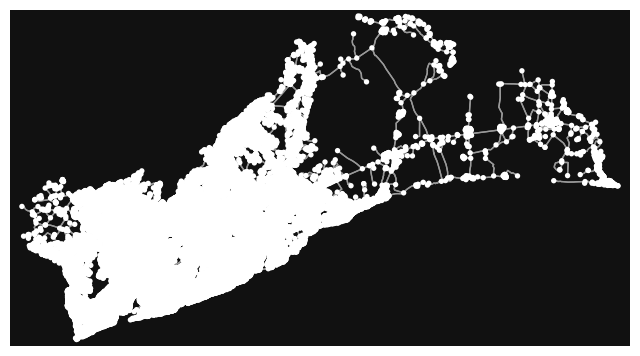

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
%time G = ox.graph_from_place('Greater Accra, Ghana', network_type='drive', simplify=True)

# Add speeds 
for u, v, key, data in G.edges(data=True, keys=True):
    highway = data.get('highway', 'unclassified')
    if isinstance(highway, list): highway = highway[0]  # Fix for lists
    speeds = {'motorway': 80, 'trunk': 70, 'primary': 60, 'secondary': 50, 'tertiary': 40, 'residential': 25}
    G[u][v][key]['speed_kmh'] = speeds.get(highway, 30)
    G[u][v][key]['travel_time'] = data.get('length', 100) / 1000 / speeds.get(highway, 30)

# Save and plot
ox.save_graphml(G, 'accra_roads.graphml')
ox.plot_graph(G)

In [6]:
# get the node, edge geometries
N, E = ox.graph_to_gdfs(G)

# project the network to web mercator
N = N.to_crs(3857)
E = E.to_crs(3857)

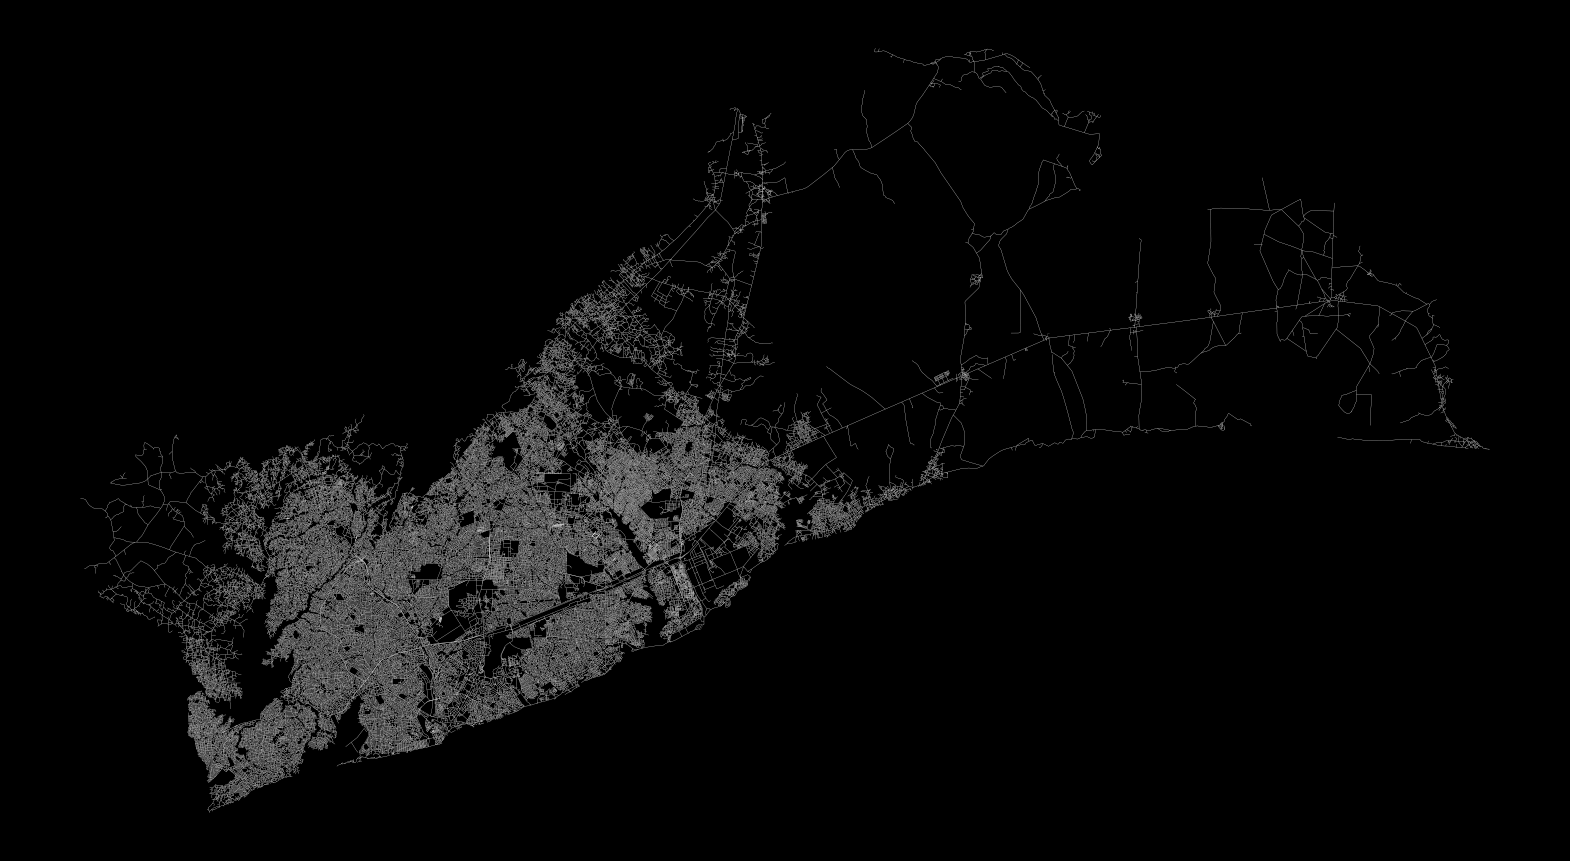

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20), facecolor = 'k')

E.plot(color='w', ax=ax, linewidth=0.1)
ax.set_axis_off()
ax.set_facecolor('k')

In [8]:
len(hospitals)

2843

In [9]:
hospitals_acc = hospitals

# Filter hospitals to include only those located in the Greater Accra Region
#this is to much current road network
hospitals_accra = hospitals_acc[hospitals_acc['Region'].str.contains("Greater Accra")].copy()

# Create a geometry column using Shapely Point objects from lat/lon values
# This column will be used to convert the DataFrame into a spatial GeoDataFrame
hospitals_accra['geometry'] = hospitals_accra.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert the DataFrame into a GeoDataFrame (WG84 CRS)
# EPSG:4326 corresponds to WGS84 – the standard lat/lon geographic system 
hospitals_accra = gpd.GeoDataFrame(hospitals_accra, geometry='geometry', crs="EPSG:4326")

# Extract latitude and longitude from the geometry column
# I want to keep these as separate columns for analysis, display, or exporting
hospitals_accra['lat'] = hospitals_accra.geometry.y  # latitude (north-south)
hospitals_accra['lon'] = hospitals_accra.geometry.x  # longitude (east-west)

# Project the data to match the coordinate system of your road network
# EPSG:3857 is the Web Mercator projection, commonly used for network and distance analysis in metres
hospitals_accra = hospitals_accra.to_crs(epsg=3857)


#  Extract x and y coordinates (in metres) from the newly projected geometry
# These values represent the position in a 2D Cartesian plane – useful for snapping, routing, or spatial queries
hospitals_accra['x'] = hospitals_accra.geometry.x  # x-coordinate (easting)
hospitals_accra['y'] = hospitals_accra.geometry.y  # y-coordinate (northing)



hospitals_accra # show table


,OBJECTID,Region,District,FacilityNa,Type,Town,Ownership,latitude,longitude,geometry,lat,lon,x,y
1283,1284,Greater Accra,Accra Metropolitan,Arakan Maternity Home,Maternity Home,Burma Camp,Quasi-Government,5.59714,-0.15088,POINT (-16795.885 624064.145),5.59714,-0.15088,-16795.884771,624064.144536
1284,1285,Greater Accra,Accra Metropolitan,Arakan Medical Centre,Clinic,Burma Camp,Quasi-Government,5.59714,-0.15088,POINT (-16795.885 624064.145),5.59714,-0.15088,-16795.884771,624064.144536
1285,1286,Greater Accra,Accra Metropolitan,1st Foundation Clinic,Clinic,Dansoman (Control market),Private,5.54182,-0.26480,POINT (-29477.401 617876.741),5.54182,-0.26480,-29477.401162,617876.740805
1286,1287,Greater Accra,Accra Metropolitan,37 Military Hospital,Psychiatric Hospital,37,Quasi-Government,5.58704,-0.18391,POINT (-20472.768 622934.441),5.58704,-0.18391,-20472.767552,622934.441264
1287,1288,Greater Accra,Accra Metropolitan,441 Welfare Association Clinic,Clinic,Nima,Private,5.58446,-0.19419,POINT (-21617.132 622645.867),5.58446,-0.19419,-21617.131917,622645.866722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,1716,Greater Accra,Accra Metropolitan,VRA Clinic,Clinic,Osu,Quasi-Government,5.55437,-0.18078,POINT (-20124.338 619280.376),5.55437,-0.18078,-20124.337546,619280.375896
1716,1717,Greater Accra,Ga East,We Care Medical centre,Clinic,Madina,Private,5.67844,-0.17433,POINT (-19406.327 633158.41),5.67844,-0.17433,-19406.326830,633158.410497
1717,1718,Greater Accra,Tema Metropolitan,White Eagle Clinic,Clinic,Sakumano Estate,Private,5.62420,-0.06929,POINT (-7713.328 627090.951),5.62420,-0.06929,-7713.327517,627090.950778
1718,1719,Greater Accra,Accra Metropolitan,White House Clinic,Clinic,Dansoman (Ebenezer rd),Private,5.53620,-0.26569,POINT (-29576.476 617248.19),5.53620,-0.26569,-29576.475509,617248.190383


- Now I know the hospital data is clipped just to Greater Accra. Now moving on moving to
- Add the hospital points to the nearest node in the network.

In [10]:
# get the nearest network node to each point
hospitals_accra['nodes'] = ox.nearest_nodes(G, hospitals_accra['lon'], hospitals_accra['lat'])

In [11]:
# get the shortest paths from all the nodes to all the entraces nodes
%time lines = nx.multi_source_dijkstra_path(G, set(hospitals_accra['nodes'].to_numpy()), weight='length')
# voronoi cells creates a voronoi using the network rather than euclidean distance
%time cells = nx.voronoi_cells(G, set(hospitals_accra['nodes'].to_numpy()), weight='length')

CPU times: user 580 ms, sys: 0 ns, total: 580 ms
Wall time: 580 ms
CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.14 s


In [12]:
cells = [pd.DataFrame({'parent': x[0], 'child': list(x[1])}) for x in cells.items()]
merged = pd.concat(cells).merge(N, left_on='child', right_on='osmid', how='left')

In [13]:
n = merged['parent'].value_counts().reset_index()
n['log_count'] = np.log(n['count'] + 1)
n

,parent,count,log_count
0,4458123476,5269,8.569786
1,5653539670,4328,8.373092
2,5613408163,3354,8.118207
3,5114341777,3189,8.067776
4,5984385600,3007,8.009031
...,...,...,...
399,6010684773,1,0.693147
400,128159129,1,0.693147
401,6277641724,1,0.693147
402,10786358819,1,0.693147


The parent is the road network node to which a group of hospitals is assigned, usually the one closest to each hospital.

I'm trying to group hospitals by which node they belong to, and then use that to build catchment areas along the network (like "this group of hospitals is connected to this road node").

Text(0.01, 0.02, 'Colours represent different hospital catchments (by nearest road node)')

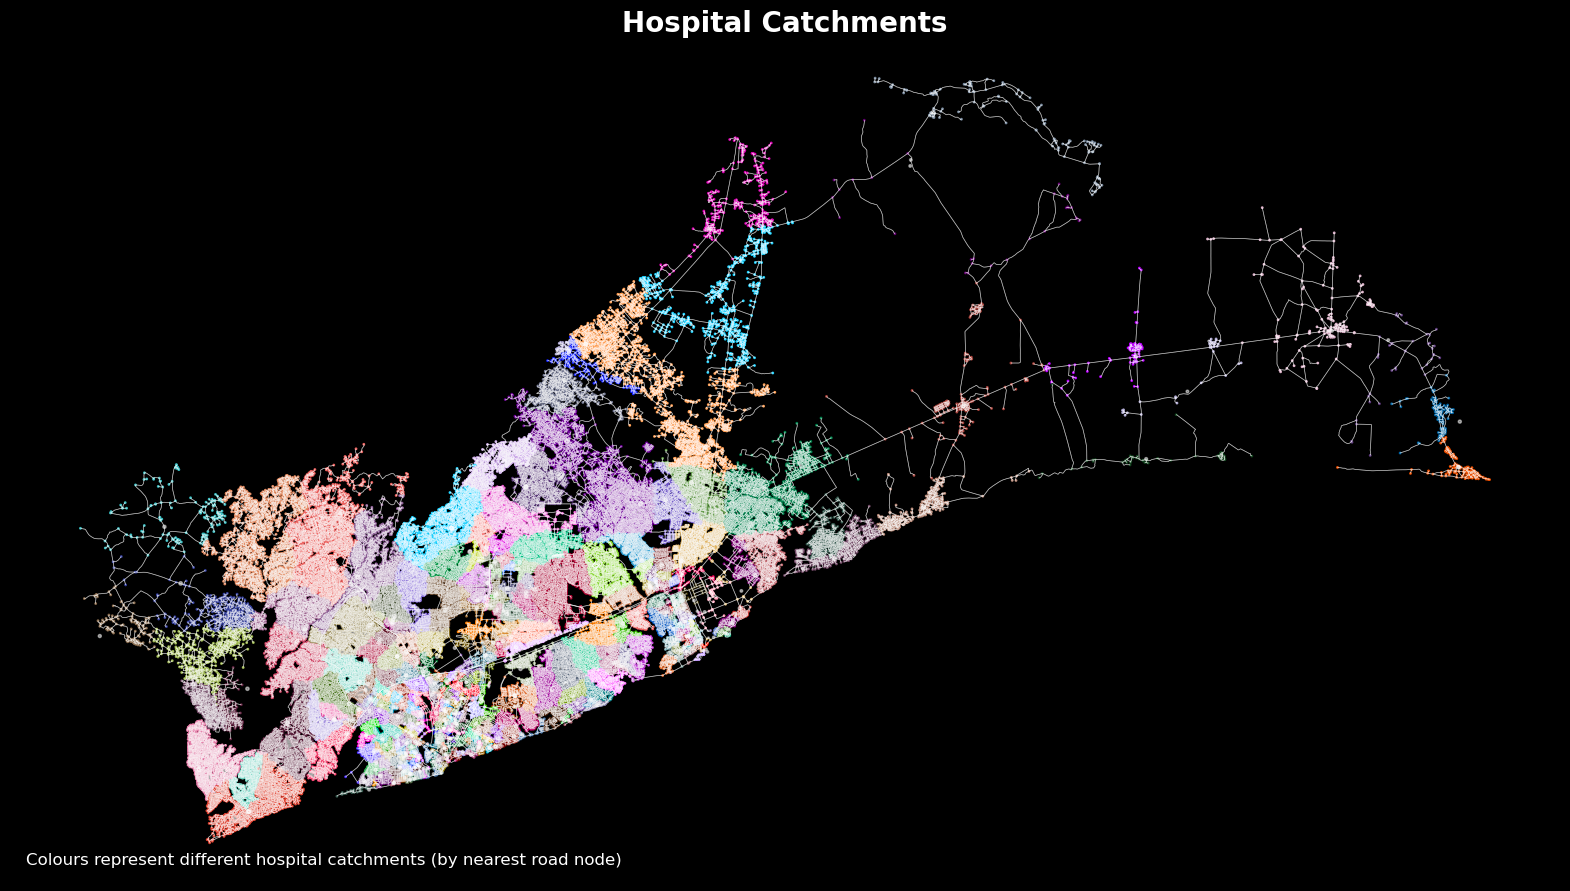

In [14]:
# plot the edges in black
fig, ax = plt.subplots(figsize=(20, 20), facecolor='k')
E.plot(color='w', ax=ax, linewidth=0.5, alpha=0.5)

# convert the merge cell dataframe to a geodataframe and plot it
gpd.GeoDataFrame(merged,
                 geometry=gpd.points_from_xy(merged['x'], merged['y']),
                 crs=4326).to_crs('3857').plot('parent', markersize=1, cmap=cc.cm.glasbey_dark, ax=ax)

# plot the stores in light grey to highlight them
hospitals_accra.merge(n, left_on='nodes', right_on='parent').plot(color='w', ax=ax, markersize='log_count', alpha=0.5)

# clean it up
ax.set_axis_off()
ax.set_facecolor('k')

# add a title
ax.set_title('Hospital Catchments', fontsize=20, fontweight='bold', color='w')

# ✅ Add explanation for colours (catchment groups)
ax.text(
    0.01, 0.02,  # position in axis coordinates (bottom-left)
    "Colours represent different hospital catchments (by nearest road node)",
    transform=ax.transAxes,
    fontsize=12,
    color='w',
    backgroundcolor='black'
)

In [15]:
# Phase 2: Population and Malaria Data Processing
print("=" * 50)
print("Phase 2: Processing Population and Malaria Data")
print("=" * 50)


Phase 2: Processing Population and Malaria Data


In [16]:
# Phase 2.1: Create Analysis Grid for Greater Accra
print("\n" + "="*50)
print("Phase 2.1: Creating 1km Analysis Grid")
print("="*50)

# Get bounds of Greater Accra (in projected coordinates)
bounds = hospitals_accra.total_bounds
print(f"Greater Accra bounds: {bounds}")

# Calculate grid dimensions
grid_size = 1000  # 1km cells in meters


Phase 2.1: Creating 1km Analysis Grid
Greater Accra bounds: [-54884.96174072 613399.84714471  69963.18676866 677557.85736918]


In [17]:
# Phase 2.2: Calculate Grid Dimensions
print(f"\nCalculating grid dimensions...")

# Extract bounds
minx, miny, maxx, maxy = bounds

# Calculate number of cells needed
width_km = (maxx - minx) / 1000
height_km = (maxy - miny) / 1000
total_cells = int(width_km) * int(height_km)

print(f"Grid dimensions:")
print(f"  Width: {width_km:.1f} km ({int(width_km)} cells)")
print(f"  Height: {height_km:.1f} km ({int(height_km)} cells)")
print(f"  Total cells: ~{total_cells:,}")


Calculating grid dimensions...
Grid dimensions:
  Width: 124.8 km (124 cells)
  Height: 64.2 km (64 cells)
  Total cells: ~7,936


In [18]:
# Phase 2.3: Create Grid Polygons
print(f"\nCreating {total_cells:,} grid polygons...")

# Import libraries we need
from shapely.geometry import Polygon  # For creating rectangular shapes
import numpy as np                    # For numerical operations

# Create empty lists to store our grid data
grid_polygons = []  # Will store the actual rectangle shapes
grid_ids = []       # Will store unique ID numbers for each cell

# Start counting cells from 0
cell_id = 0

# Create a grid by going through each row and column
# Think of it like a chess board - we go through each square
for i in range(int(width_km)):      # Go through each column (left to right)
    for j in range(int(height_km)): # Go through each row (bottom to top)
        
        # Calculate where this cell should be positioned
        # Each cell is 1km × 1km (1000 meters × 1000 meters)
        left = minx + (i * grid_size)        # Left edge of the cell
        right = minx + ((i + 1) * grid_size) # Right edge of the cell  
        bottom = miny + (j * grid_size)      # Bottom edge of the cell
        top = miny + ((j + 1) * grid_size)   # Top edge of the cell
        
        # Create a rectangular polygon using the 4 corners
        # We start from bottom-left and go clockwise
        cell_polygon = Polygon([
            (left, bottom),   # Bottom-left corner
            (right, bottom),  # Bottom-right corner
            (right, top),     # Top-right corner
            (left, top)       # Top-left corner
        ])
        
        # Add this cell to our lists
        grid_polygons.append(cell_polygon)  # Store the rectangle shape
        grid_ids.append(cell_id)           # Store the ID number
        
        # Move to next cell ID
        cell_id += 1

print(f"✓ Created {len(grid_polygons):,} grid cells")


Creating 7,936 grid polygons...
✓ Created 7,936 grid cells


Created a grid of squares over Greater Accra. Small enough for detailed analysis. For each square, we calculate its exact position. We create a rectangle shape - using the 4 corner coordinates. We store each rectangle - so we can use it later for analysis.
- Next converting the polygons into a proper GeoDataFrame

In [19]:
# Phase 2.4: Convert Grid to GeoDataFrame
print(f"\nConverting grid to GeoDataFrame...")

# Create a GeoDataFrame (like a spreadsheet with map shapes)
# This combines our polygon shapes with data we can analyze
analysis_grid = gpd.GeoDataFrame({
    'cell_id': grid_ids,           # Column 1: Unique ID for each cell (0, 1, 2, ...)
    'geometry': grid_polygons      # Column 2: The actual rectangle shapes
}, crs='EPSG:3857')               # Tell it we're using Web Mercator coordinates

# Add some basic information columns (we'll fill these with data later)
analysis_grid['population'] = 0           # Will store population count per cell
analysis_grid['malaria_incidence'] = 0    # Will store malaria rate per cell
analysis_grid['has_hospital'] = False     # Will mark if cell contains a hospital
analysis_grid['malaria_burden'] = 0       # Will store total malaria cases per cell

# Show summary
print(f"✓ Created analysis grid:")
print(f"  Total cells: {len(analysis_grid):,}")
print(f"  Coordinate system: {analysis_grid.crs}")
print(f"  Columns: {list(analysis_grid.columns)}")

# Show first few rows to check it looks right
print(f"\nFirst 3 cells:")
print(analysis_grid.head(3))


Converting grid to GeoDataFrame...
✓ Created analysis grid:
  Total cells: 7,936
  Coordinate system: EPSG:3857
  Columns: ['cell_id', 'geometry', 'population', 'malaria_incidence', 'has_hospital', 'malaria_burden']

First 3 cells:
   cell_id                                           geometry  population  \
0        0  POLYGON ((-54884.962 613399.847, -53884.962 61...           0   
1        1  POLYGON ((-54884.962 614399.847, -53884.962 61...           0   
2        2  POLYGON ((-54884.962 615399.847, -53884.962 61...           0   

   malaria_incidence  has_hospital  malaria_burden  
0                  0         False               0  
1                  0         False               0  
2                  0         False               0  


Created a spreadsheet with map shapes - each row is one 1km cell. Created empty columns - ready to fill with population, malaria data, etc later. Set coordinate system (Coordinate system: EPSG:3857).

In [20]:
# Phase 2.5: Mark Grid Cells That Contain Hospitals
print(f"\nIdentifying which grid cells contain hospitals...")

# Counter to track how many cells have hospitals
hospital_cells_count = 0

# Go through each hospital one by one
for idx, hospital in hospitals_accra.iterrows():
    
    # Get the location of this hospital (as a point on the map)
    hospital_point = hospital.geometry
    
    # Find which grid cell contains this hospital
    # This checks if the hospital point falls inside any of our 1km squares
    containing_cells = analysis_grid[analysis_grid.contains(hospital_point)]
    
    # If we found a cell that contains this hospital
    if not containing_cells.empty:
        # Get the index (row number) of that cell
        cell_idx = containing_cells.index[0]
        
        # Mark that cell as having a hospital
        analysis_grid.loc[cell_idx, 'has_hospital'] = True
        
        # Count this cell
        hospital_cells_count += 1
        
        # Optional: print progress every 50 hospitals
        if (idx + 1) % 50 == 0:
            print(f"  Processed {idx + 1} hospitals...")

# Show results
cells_with_hospitals = analysis_grid['has_hospital'].sum()
print(f"✓ Processed {len(hospitals_accra)} hospitals")
print(f"✓ Found {cells_with_hospitals} grid cells containing hospitals")
print(f"✓ Average: {len(hospitals_accra)/cells_with_hospitals:.1f} hospitals per cell")


Identifying which grid cells contain hospitals...
  Processed 1300 hospitals...
  Processed 1350 hospitals...
  Processed 1400 hospitals...
  Processed 1450 hospitals...
  Processed 1500 hospitals...
  Processed 1550 hospitals...
  Processed 1600 hospitals...
  Processed 1650 hospitals...
  Processed 1700 hospitals...
✓ Processed 437 hospitals
✓ Found 234 grid cells containing hospitals
✓ Average: 1.9 hospitals per cell


This means hospitals are clustered - some cells have multiple hospitals while most cells have none. This is typical for urban areas where hospitals cluster in medical districts.

Now adding population data to the grid

In [21]:
# Phase 2.6: Add Population Data to Grid (Robust Version)
print(f"\nAdding population data to grid cells...")

# Check if we have our analysis_grid variable
try:
    print(f"Analysis grid exists: {len(analysis_grid)} cells")
except NameError:
    print("⚠️ Analysis grid not found. Please run previous phases first.")
    print("Stopping here - run phases 2.1 through 2.5 first")
    raise SystemExit("Missing analysis_grid variable")

# Install rasterstats if needed
try:
    from rasterstats import zonal_stats
    print("✓ rasterstats library ready")
except ImportError:
    print("Installing rasterstats...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rasterstats"])
    from rasterstats import zonal_stats
    print("✓ rasterstats installed and imported")

# Continue with population calculation...
print("Ready to process population data")


Adding population data to grid cells...
Analysis grid exists: 7936 cells
✓ rasterstats library ready
Ready to process population data


In [22]:
# Load the population raster file
print("Loading population raster...")
population_file = 'DATA/ghana_population_constrained/gha_ppp_2020.tif'

# Calculate population sum for each grid cell
print("Calculating population for each grid cell...")
print("(Processing 7,936 cells - this may take 2-3 minutes...)")

# Process in smaller batches to avoid memory issues
batch_size = 1000  # Process 1000 cells at a time
total_batches = len(analysis_grid) // batch_size + 1

print(f"Processing in {total_batches} batches of {batch_size} cells each...")

Loading population raster...
Calculating population for each grid cell...
(Processing 7,936 cells - this may take 2-3 minutes...)
Processing in 8 batches of 1000 cells each...


In [23]:
# Alternative approach - use rasterio directly (more memory efficient)
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np

print("Testing alternative population approach...")

# First, let's check the population raster file properties
population_file = 'DATA/ghana_population_constrained/gha_ppp_2020.tif'

try:
    with rasterio.open(population_file) as src:
        print(f"Population raster info:")
        print(f"  Size: {src.width} x {src.height}")
        print(f"  CRS: {src.crs}")
        print(f"  Bounds: {src.bounds}")
        print(f"  Data type: {src.dtypes[0]}")
        
except Exception as e:
    print(f"Error reading raster: {e}")
    print("Let's check if the file path is correct...")
    
    # Check file existence
    import os
    if os.path.exists(population_file):
        print("✓ File exists")
        print(f"File size: {os.path.getsize(population_file) / (1024*1024):.1f} MB")
    else:
        print("✗ File not found")

Testing alternative population approach...
Population raster info:
  Size: 5337 x 7721
  CRS: EPSG:4326
  Bounds: BoundingBox(left=-3.255416639, bottom=4.738750182, right=1.1920833430000002, top=11.172916823)
  Data type: float32


In [24]:
# Phase 2.6: Add Population Data to Grid
print("\n" + "="*50)
print("Phase 2.6: Adding Population Data to Grid")
print("="*50)

# Import the raster processing library
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds

print("Setting up population data processing...")

# Population raster file path
population_file = 'DATA/ghana_population_constrained/gha_ppp_2020.tif'

# Check the population raster properties first
with rasterio.open(population_file) as src:
    pop_crs = src.crs
    pop_bounds = src.bounds
    pop_shape = (src.height, src.width)
    print(f"Population raster CRS: {pop_crs}")
    print(f"Population raster bounds: {pop_bounds}")
    print(f"Population raster shape: {pop_shape}")

# Check our analysis grid CRS
print(f"Analysis grid CRS: {analysis_grid.crs}")
print(f"Analysis grid cells: {len(analysis_grid)}")

# Make sure coordinate systems match
if str(analysis_grid.crs) != str(pop_crs):
    print("⚠️ CRS mismatch detected - will need to transform coordinates")
else:
    print("✓ CRS match - can proceed directly")


Phase 2.6: Adding Population Data to Grid
Setting up population data processing...
Population raster CRS: EPSG:4326
Population raster bounds: BoundingBox(left=-3.255416639, bottom=4.738750182, right=1.1920833430000002, top=11.172916823)
Population raster shape: (7721, 5337)
Analysis grid CRS: EPSG:3857
Analysis grid cells: 7936
⚠️ CRS mismatch detected - will need to transform coordinates


In [25]:
# Transform analysis grid to match population raster CRS
print("Transforming analysis grid to EPSG:4326 to match population raster...")

# Create a copy of the grid in the raster's coordinate system
analysis_grid_4326 = analysis_grid.to_crs('EPSG:4326')

print(f"✓ Transformed grid to EPSG:4326")
print(f"Original grid bounds (EPSG:3857): {analysis_grid.total_bounds}")
print(f"Transformed grid bounds (EPSG:4326): {analysis_grid_4326.total_bounds}")

# Check if transformed grid overlaps with population raster
grid_bounds = analysis_grid_4326.total_bounds
raster_bounds = pop_bounds

print(f"\nChecking overlap:")
print(f"Grid bounds:   [{grid_bounds[0]:.3f}, {grid_bounds[1]:.3f}, {grid_bounds[2]:.3f}, {grid_bounds[3]:.3f}]")
print(f"Raster bounds: [{raster_bounds[0]:.3f}, {raster_bounds[1]:.3f}, {raster_bounds[2]:.3f}, {raster_bounds[3]:.3f}]")

# Check if there's overlap
overlap = (grid_bounds[0] < raster_bounds[2] and grid_bounds[2] > raster_bounds[0] and
           grid_bounds[1] < raster_bounds[3] and grid_bounds[3] > raster_bounds[1])

if overlap:
    print("✓ Grid and raster overlap - can proceed with population extraction")
else:
    print("⚠️ No overlap detected - need to check coordinates")

Transforming analysis grid to EPSG:4326 to match population raster...
✓ Transformed grid to EPSG:4326
Original grid bounds (EPSG:3857): [-54884.96174072 613399.84714471  69115.03825928 677399.84714471]
Transformed grid bounds (EPSG:4326): [-0.49304     5.50179     0.62087095  6.07377854]

Checking overlap:
Grid bounds:   [-0.493, 5.502, 0.621, 6.074]
Raster bounds: [-3.255, 4.739, 1.192, 11.173]
✓ Grid and raster overlap - can proceed with population extraction


In [26]:
# Extract population data using small batches
print("Starting population extraction with small test batch...")

# Try rasterstats with the transformed grid (small test first)
try:
    from rasterstats import zonal_stats
    print("✓ rasterstats available")
    
    # Test with first 5 cells only
    test_cells = 5
    print(f"Testing with {test_cells} cells...")
    
    test_geometries = analysis_grid_4326.geometry.iloc[0:test_cells]
    
    # Extract population for test cells
    test_pop_stats = zonal_stats(
        vectors=test_geometries,
        raster=population_file,
        stats=['sum', 'count'],
        nodata=-99999
    )
    
    print(f"✓ Test successful! Results for {len(test_pop_stats)} cells:")
    for i, stats in enumerate(test_pop_stats):
        pop = stats['sum'] if stats['sum'] is not None else 0
        print(f"  Cell {i}: {pop:.0f} people")
        
    print("Ready to process all cells in batches!")
    
except ImportError:
    print("rasterstats not available - will use alternative method")
except Exception as e:
    print(f"Error in test: {e}")

Starting population extraction with small test batch...
✓ rasterstats available
Testing with 5 cells...
✓ Test successful! Results for 5 cells:
  Cell 0: 956 people
  Cell 1: 2090 people
  Cell 2: 2114 people
  Cell 3: 1521 people
  Cell 4: 686 people
Ready to process all cells in batches!


In [27]:
# Process all 7,936 cells in manageable batches
print(f"Processing all {len(analysis_grid_4326)} cells in batches...")

batch_size = 100  # Small batches to avoid memory issues
total_cells = len(analysis_grid_4326)
num_batches = (total_cells // batch_size) + 1

print(f"Will process {num_batches} batches of {batch_size} cells each")

# Initialize list to store all population results
all_population_data = []

# Process in batches
for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = min(start_idx + batch_size, total_cells)
    
    if start_idx >= total_cells:
        break
        
    print(f"Processing batch {batch_num + 1}/{num_batches}: cells {start_idx} to {end_idx-1}")
    
    # Get geometries for this batch
    batch_geoms = analysis_grid_4326.geometry.iloc[start_idx:end_idx]
    
    # Extract population for this batch
    batch_pop_stats = zonal_stats(
        vectors=batch_geoms,
        raster=population_file,
        stats=['sum'],
        nodata=-99999
    )
    
    # Store results
    all_population_data.extend(batch_pop_stats)
    
    # Show progress every 10 batches
    if (batch_num + 1) % 10 == 0:
        print(f"  Completed {batch_num + 1} batches ({len(all_population_data)} cells processed)")

print(f"✓ Completed! Processed {len(all_population_data)} cells total")

Processing all 7936 cells in batches...
Will process 80 batches of 100 cells each
Processing batch 1/80: cells 0 to 99
Processing batch 2/80: cells 100 to 199
Processing batch 3/80: cells 200 to 299
Processing batch 4/80: cells 300 to 399
Processing batch 5/80: cells 400 to 499
Processing batch 6/80: cells 500 to 599
Processing batch 7/80: cells 600 to 699
Processing batch 8/80: cells 700 to 799
Processing batch 9/80: cells 800 to 899
Processing batch 10/80: cells 900 to 999
  Completed 10 batches (1000 cells processed)
Processing batch 11/80: cells 1000 to 1099
Processing batch 12/80: cells 1100 to 1199
Processing batch 13/80: cells 1200 to 1299
Processing batch 14/80: cells 1300 to 1399
Processing batch 15/80: cells 1400 to 1499
Processing batch 16/80: cells 1500 to 1599
Processing batch 17/80: cells 1600 to 1699
Processing batch 18/80: cells 1700 to 1799
Processing batch 19/80: cells 1800 to 1899
Processing batch 20/80: cells 1900 to 1999
  Completed 20 batches (2000 cells processed

In [31]:
# Add population data to the analysis grid
print("Adding population data to analysis grid...")

# Extract population values from the results
population_values = []
for stats in all_population_data:
    pop = stats['sum'] if stats['sum'] is not None else 0
    population_values.append(pop)

# Add to the analysis grid
analysis_grid['population'] = population_values

# Show summary statistics
total_population = analysis_grid['population'].sum()
max_population = analysis_grid['population'].max()
avg_population = analysis_grid['population'].mean()
cells_with_people = (analysis_grid['population'] > 0).sum()

print(f"✓ Population data added to grid")
print(f"Population Summary:")
print(f"  Total population: {total_population:,.0f}")
print(f"  Average per cell: {avg_population:.0f}")
print(f"  Maximum per cell: {max_population:.0f}")
print(f"  Cells with population: {cells_with_people:,} / {len(analysis_grid):,}")
print(f"  Empty cells: {len(analysis_grid) - cells_with_people:,}")

# Show first few rows
print(f"\nFirst 5 cells with population data:")
print(analysis_grid[['cell_id', 'population', 'has_hospital']].head(10))

Adding population data to analysis grid...
✓ Population data added to grid
Population Summary:
  Total population: 6,427,390
  Average per cell: 810
  Maximum per cell: 25651
  Cells with population: 5,833 / 7,936
  Empty cells: 2,103

First 5 cells with population data:
   cell_id   population  has_hospital
0        0   956.035950         False
1        1  2089.564941         False
2        2  2114.445557         False
3        3  1520.587769         False
4        4   686.272461         False
5        5   630.862488         False
6        6   671.458557         False
7        7   392.547699         False
8        8   416.046875         False
9        9   452.464111         False


#### now adding malaria data to grid

In [34]:
# Phase 2.7: Add Malaria Incidence Data
print("\n" + "="*50)
print("Phase 2.7: Adding Malaria Incidence Data")
print("="*50)

# Malaria raster file
malaria_file = 'DATA/ghana_malaria_incidence/2020_Global_Pf_Incidence_GHA_2019.tiff'

# Check malaria raster properties
with rasterio.open(malaria_file) as src:
    malaria_crs = src.crs
    malaria_bounds = src.bounds
    malaria_shape = (src.height, src.width)
    print(f"Malaria raster CRS: {malaria_crs}")
    print(f"Malaria raster bounds: {malaria_bounds}")
    print(f"Malaria raster shape: {malaria_shape}")

# Check if we need coordinate transformation
if str(analysis_grid_4326.crs) == str(malaria_crs):
    print("✓ CRS match with grid - can proceed directly")
    grid_for_malaria = analysis_grid_4326
else:
    print("⚠️ CRS mismatch - will transform grid")
    grid_for_malaria = analysis_grid_4326.to_crs(malaria_crs)

# Check overlap
grid_bounds = grid_for_malaria.total_bounds
print(f"\nChecking overlap:")
print(f"Grid bounds:    [{grid_bounds[0]:.3f}, {grid_bounds[1]:.3f}, {grid_bounds[2]:.3f}, {grid_bounds[3]:.3f}]")
print(f"Malaria bounds: [{malaria_bounds[0]:.3f}, {malaria_bounds[1]:.3f}, {malaria_bounds[2]:.3f}, {malaria_bounds[3]:.3f}]")

overlap = (grid_bounds[0] < malaria_bounds[2] and grid_bounds[2] > malaria_bounds[0] and
           grid_bounds[1] < malaria_bounds[3] and grid_bounds[3] > malaria_bounds[1])

if overlap:
    print("✓ Grid and malaria raster overlap - ready for extraction")
else:
    print("⚠️ No overlap detected")


Phase 2.7: Adding Malaria Incidence Data
Malaria raster CRS: EPSG:4326
Malaria raster bounds: BoundingBox(left=-3.2666158510964487, bottom=4.727057328253447, right=1.1910743118705969, top=11.182914533498105)
Malaria raster shape: (155, 107)
✓ CRS match with grid - can proceed directly

Checking overlap:
Grid bounds:    [-0.493, 5.502, 0.621, 6.074]
Malaria bounds: [-3.267, 4.727, 1.191, 11.183]
✓ Grid and malaria raster overlap - ready for extraction


In [35]:
# Extract malaria incidence data
print("Extracting malaria incidence data...")

# Test with small batch first
test_cells = 5
print(f"Testing with {test_cells} cells...")

test_geometries = analysis_grid_4326.geometry.iloc[0:test_cells]

# Extract malaria incidence for test cells
test_malaria_stats = zonal_stats(
    vectors=test_geometries,
    raster=malaria_file,
    stats=['mean'],  # Use mean for incidence rates
    nodata=-99999
)

print(f"✓ Test successful! Malaria incidence results for {len(test_malaria_stats)} cells:")
for i, stats in enumerate(test_malaria_stats):
    incidence = stats['mean'] if stats['mean'] is not None else 0
    print(f"  Cell {i}: {incidence:.3f} cases per 1000 population")

print("Ready to process all cells for malaria data!")

Extracting malaria incidence data...
Testing with 5 cells...
✓ Test successful! Malaria incidence results for 5 cells:
  Cell 0: 0.000 cases per 1000 population
  Cell 1: 0.000 cases per 1000 population
  Cell 2: 0.000 cases per 1000 population
  Cell 3: 0.000 cases per 1000 population
  Cell 4: 0.000 cases per 1000 population
Ready to process all cells for malaria data!


In [36]:
# Process all cells for malaria incidence
print(f"Processing all {len(analysis_grid_4326)} cells for malaria data...")

batch_size = 200  # Larger batches since malaria raster is smaller
total_cells = len(analysis_grid_4326)
num_batches = (total_cells // batch_size) + 1

print(f"Will process {num_batches} batches of {batch_size} cells each")

# Initialize list to store all malaria results
all_malaria_data = []

# Process in batches
for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = min(start_idx + batch_size, total_cells)
    
    if start_idx >= total_cells:
        break
        
    print(f"Processing batch {batch_num + 1}/{num_batches}: cells {start_idx} to {end_idx-1}")
    
    # Get geometries for this batch
    batch_geoms = analysis_grid_4326.geometry.iloc[start_idx:end_idx]
    
    # Extract malaria incidence for this batch
    batch_malaria_stats = zonal_stats(
        vectors=batch_geoms,
        raster=malaria_file,
        stats=['mean', 'min', 'max', 'count'],  # Get more stats to understand the data
        nodata=-99999
    )
    
    # Store results
    all_malaria_data.extend(batch_malaria_stats)
    
    # Show progress every 5 batches
    if (batch_num + 1) % 5 == 0:
        print(f"  Completed {batch_num + 1} batches ({len(all_malaria_data)} cells processed)")

print(f"✓ Completed! Processed {len(all_malaria_data)} cells total")

# Quick analysis of results
non_zero_count = sum(1 for stats in all_malaria_data if stats['mean'] is not None and stats['mean'] > 0)
print(f"Cells with non-zero malaria incidence: {non_zero_count} / {len(all_malaria_data)}")

Processing all 7936 cells for malaria data...
Will process 40 batches of 200 cells each
Processing batch 1/40: cells 0 to 199
Processing batch 2/40: cells 200 to 399
Processing batch 3/40: cells 400 to 599
Processing batch 4/40: cells 600 to 799
Processing batch 5/40: cells 800 to 999
  Completed 5 batches (1000 cells processed)
Processing batch 6/40: cells 1000 to 1199
Processing batch 7/40: cells 1200 to 1399
Processing batch 8/40: cells 1400 to 1599
Processing batch 9/40: cells 1600 to 1799
Processing batch 10/40: cells 1800 to 1999
  Completed 10 batches (2000 cells processed)
Processing batch 11/40: cells 2000 to 2199
Processing batch 12/40: cells 2200 to 2399
Processing batch 13/40: cells 2400 to 2599
Processing batch 14/40: cells 2600 to 2799
Processing batch 15/40: cells 2800 to 2999
  Completed 15 batches (3000 cells processed)
Processing batch 16/40: cells 3000 to 3199
Processing batch 17/40: cells 3200 to 3399
Processing batch 18/40: cells 3400 to 3599
Processing batch 19/40

In [37]:
# Add malaria incidence data to the analysis grid
print("Adding malaria incidence data to analysis grid...")

# Extract malaria incidence values
malaria_incidence_values = []
for stats in all_malaria_data:
    incidence = stats['mean'] if stats['mean'] is not None else 0
    malaria_incidence_values.append(incidence)

# Add to the analysis grid
analysis_grid['malaria_incidence'] = malaria_incidence_values

# Calculate malaria burden (total cases per cell)
# Malaria burden = (incidence per 1000) * (population / 1000)
analysis_grid['malaria_burden'] = (analysis_grid['malaria_incidence'] * analysis_grid['population']) / 1000

# Show summary statistics
total_malaria_burden = analysis_grid['malaria_burden'].sum()
max_incidence = analysis_grid['malaria_incidence'].max()
avg_incidence = analysis_grid['malaria_incidence'].mean()
cells_with_malaria = (analysis_grid['malaria_incidence'] > 0).sum()

print(f"✓ Malaria data added to grid")
print(f"Malaria Summary:")
print(f"  Cells with malaria: {cells_with_malaria:,} / {len(analysis_grid):,}")
print(f"  Max incidence rate: {max_incidence:.3f} cases per 1000")
print(f"  Average incidence: {avg_incidence:.3f} cases per 1000")
print(f"  Total malaria burden: {total_malaria_burden:.0f} cases annually")

# Show sample of cells with highest malaria burden
print(f"\nTop 5 cells by malaria burden:")
top_malaria = analysis_grid.nlargest(5, 'malaria_burden')[['cell_id', 'population', 'malaria_incidence', 'malaria_burden', 'has_hospital']]
print(top_malaria)

Adding malaria incidence data to analysis grid...
✓ Malaria data added to grid
Malaria Summary:
  Cells with malaria: 244 / 7,936
  Max incidence rate: 0.326 cases per 1000
  Average incidence: -117.170 cases per 1000
  Total malaria burden: -109939 cases annually

Top 5 cells by malaria burden:
      cell_id    population  malaria_incidence  malaria_burden  has_hospital
1732     1732  19024.441406           0.143811        2.735923          True
2056     2056  24690.265625           0.110153        2.719710          True
2312     2312  15294.851562           0.131006        2.003718         False
1736     1736  16183.832031           0.120478        1.949796          True
1741     1741  10411.187500           0.114532        1.192410         False


In [38]:
# Phase 2.8: Create Summary Visualization
print("\n" + "="*50)
print("Phase 2.8: Creating Analysis Summary")
print("="*50)

# Summary statistics
print("Complete Grid Analysis Summary:")
print(f"  Total cells: {len(analysis_grid):,}")
print(f"  Populated cells: {(analysis_grid['population'] > 0).sum():,}")
print(f"  Cells with hospitals: {analysis_grid['has_hospital'].sum():,}")
print(f"  Cells with malaria: {(analysis_grid['malaria_incidence'] > 0).sum():,}")
print(f"  Total population: {analysis_grid['population'].sum():,.0f}")
print(f"  Total malaria burden: {analysis_grid['malaria_burden'].sum():.0f} cases/year")

# Create categories for analysis
analysis_grid['category'] = 'Low Priority'
analysis_grid.loc[(analysis_grid['population'] > 1000) & (analysis_grid['malaria_incidence'] > 0), 'category'] = 'Medium Priority'
analysis_grid.loc[(analysis_grid['population'] > 2000) & (analysis_grid['malaria_incidence'] > 0.1), 'category'] = 'High Priority'
analysis_grid.loc[analysis_grid['has_hospital'], 'category'] = 'Has Hospital'

# Show category breakdown
category_counts = analysis_grid['category'].value_counts()
print(f"\nPriority Categories:")
for cat, count in category_counts.items():
    print(f"  {cat}: {count:,} cells")

print(f"\n✓ Grid analysis complete - ready for optimization!")


Phase 2.8: Creating Analysis Summary
Complete Grid Analysis Summary:
  Total cells: 7,936
  Populated cells: 5,833
  Cells with hospitals: 234
  Cells with malaria: 244
  Total population: 6,427,390
  Total malaria burden: -109939 cases/year

Priority Categories:
  Low Priority: 7,659 cells
  Has Hospital: 234 cells
  High Priority: 26 cells
  Medium Priority: 17 cells

✓ Grid analysis complete - ready for optimization!


📊 Complete Analysis Summary:
Grid Coverage:

- Total cells: 7,936 (1km² each covering Greater Accra)
- Populated cells: 5,833 (73% with residents)
- Current hospital coverage: 234 cells have hospitals (4% coverage)

Health Need Analysis:

- Total population: 6,427,390 people
- Malaria affected areas: 244 cells (3% of region)
- Priority areas identified:

- 🔴 High Priority: 26 cells (high population + malaria)
- 🟡 Medium Priority: 17 cells (moderate need)
- 🟢 Low Priority: 7,659 cells
- 🏥 Has Hospital: 234 cells (current coverage)

### Phase 3: Hospital Location Optimization

In [54]:
# Phase 3: Travel Time Analysis on Road Network
print("\n" + "="*50)
print("Phase 3: Travel Time Analysis on Road Network")
print("="*50)

# Phase 3.1: Calculate Travel Times from Grid Cells to Hospitals
print("\n" + "="*50)
print("Phase 3.1: Calculating Travel Times to Hospitals")
print("="*50)

# Get hospital nodes (we created this in Phase 1)
hospital_nodes = set(hospitals_accra['nodes'].to_numpy())
print(f"✓ Found {len(hospital_nodes)} hospital network nodes")

# Phase 3.2: Calculate shortest paths from each grid cell to nearest hospital
print(f"\nCalculating travel times from {len(analysis_grid)} grid cells to nearest hospitals...")
print("(This may take several minutes...)")

import time
start_time = time.time()

# Function to find nearest network node for each grid cell centroid
def get_nearest_node_for_point(point, graph):
    """Find the nearest network node to a given point"""
    return ox.nearest_nodes(graph, point.x, point.y)

# Calculate centroids for all grid cells
print("Calculating grid cell centroids...")
analysis_grid['centroid'] = analysis_grid.geometry.centroid

# Get nearest network nodes for all grid cells
print("Finding nearest network nodes for each grid cell...")
analysis_grid['nearest_node'] = analysis_grid['centroid'].apply(
    lambda point: get_nearest_node_for_point(point, G)
)

print(f"✓ Mapped {len(analysis_grid)} grid cells to network nodes")

# Phase 3.3: Calculate travel times using NetworkX shortest path
print("\nCalculating shortest path distances to hospitals...")

# Initialize columns for travel time analysis
analysis_grid['travel_time_minutes'] = float('inf')  # Initialize with infinity
analysis_grid['nearest_hospital_node'] = None
analysis_grid['nearest_hospital_distance_m'] = float('inf')

# Process in smaller batches for memory efficiency
batch_size = 500
total_cells = len(analysis_grid)
num_batches = (total_cells // batch_size) + 1

print(f"Processing {total_cells} cells in {num_batches} batches of {batch_size} cells each...")

processed_count = 0

for batch_num in range(num_batches):
    batch_start = batch_num * batch_size
    batch_end = min((batch_num + 1) * batch_size, total_cells)
    
    print(f"Processing batch {batch_num + 1}/{num_batches} (cells {batch_start}-{batch_end})...")
    
    # Get batch of grid cell nodes
    batch_nodes = analysis_grid.iloc[batch_start:batch_end]['nearest_node'].tolist()
    
    # For each node in this batch, find shortest path to any hospital
    for i, source_node in enumerate(batch_nodes):
        cell_idx = batch_start + i
        
        try:
            # Calculate shortest path lengths from this cell to all hospital nodes
            # Using Dijkstra's algorithm with travel_time as weight
            lengths = nx.single_source_dijkstra_path_length(
                G, source_node, cutoff=3600, weight='travel_time'  # 1 hour cutoff
            )
            
            # Find the shortest path to any hospital
            min_time = float('inf')
            nearest_hospital = None
            
            for hospital_node in hospital_nodes:
                if hospital_node in lengths:
                    travel_time = lengths[hospital_node]
                    if travel_time < min_time:
                        min_time = travel_time
                        nearest_hospital = hospital_node
            
            # Convert from seconds to minutes
            if min_time != float('inf'):
                analysis_grid.loc[cell_idx, 'travel_time_minutes'] = min_time / 60
                analysis_grid.loc[cell_idx, 'nearest_hospital_node'] = nearest_hospital
                analysis_grid.loc[cell_idx, 'nearest_hospital_distance_m'] = min_time  # Keep in seconds for now
            
        except Exception as e:
            # If no path found, keep as infinity
            print(f"No path found for cell {cell_idx}: {e}")
            continue
    
    processed_count += len(batch_nodes)
    elapsed_time = time.time() - start_time
    
    if batch_num % 5 == 0:  # Print progress every 5 batches
        print(f"  Processed {processed_count}/{total_cells} cells ({processed_count/total_cells*100:.1f}%) - "
              f"Elapsed: {elapsed_time:.1f}s")

total_time = time.time() - start_time
print(f"\n✓ Travel time calculation completed in {total_time:.1f} seconds")

# Phase 3.4: Analyze accessibility results
print("\n" + "="*50)
print("Phase 3.4: Accessibility Analysis Results")
print("="*50)

# Calculate accessibility statistics
accessible_cells = analysis_grid[analysis_grid['travel_time_minutes'] != float('inf')]
inaccessible_cells = analysis_grid[analysis_grid['travel_time_minutes'] == float('inf')]

print(f"Accessibility Summary:")
print(f"  Total cells analyzed: {len(analysis_grid):,}")
print(f"  Accessible cells: {len(accessible_cells):,} ({len(accessible_cells)/len(analysis_grid)*100:.1f}%)")
print(f"  Inaccessible cells: {len(inaccessible_cells):,} ({len(inaccessible_cells)/len(analysis_grid)*100:.1f}%)")

if len(accessible_cells) > 0:
    print(f"\nTravel Time Statistics (for accessible areas):")
    print(f"  Mean travel time: {accessible_cells['travel_time_minutes'].mean():.1f} minutes")
    print(f"  Median travel time: {accessible_cells['travel_time_minutes'].median():.1f} minutes")
    print(f"  Min travel time: {accessible_cells['travel_time_minutes'].min():.1f} minutes")
    print(f"  Max travel time: {accessible_cells['travel_time_minutes'].max():.1f} minutes")
    
    # Create accessibility categories
    analysis_grid['accessibility_category'] = 'Inaccessible'
    analysis_grid.loc[analysis_grid['travel_time_minutes'] <= 15, 'accessibility_category'] = 'Excellent (<15 min)'
    analysis_grid.loc[(analysis_grid['travel_time_minutes'] > 15) & 
                     (analysis_grid['travel_time_minutes'] <= 30), 'accessibility_category'] = 'Good (15-30 min)'
    analysis_grid.loc[(analysis_grid['travel_time_minutes'] > 30) & 
                     (analysis_grid['travel_time_minutes'] <= 60), 'accessibility_category'] = 'Fair (30-60 min)'
    analysis_grid.loc[analysis_grid['travel_time_minutes'] > 60, 'accessibility_category'] = 'Poor (>60 min)'
    
    # Show accessibility breakdown
    accessibility_counts = analysis_grid['accessibility_category'].value_counts()
    print(f"\nAccessibility Categories:")
    for category, count in accessibility_counts.items():
        percentage = count / len(analysis_grid) * 100
        print(f"  {category}: {count:,} cells ({percentage:.1f}%)")

# Phase 3.5: Population-weighted accessibility analysis
print(f"\nPopulation-Weighted Accessibility Analysis:")

if len(accessible_cells) > 0:
    # Calculate population in each accessibility category
    for category in analysis_grid['accessibility_category'].unique():
        category_cells = analysis_grid[analysis_grid['accessibility_category'] == category]
        category_population = category_cells['population'].sum()
        percentage = category_population / analysis_grid['population'].sum() * 100
        print(f"  {category}: {category_population:,.0f} people ({percentage:.1f}%)")

print("\n✓ Phase 3 completed successfully!")
print("✓ Travel time analysis complete - ready for optimization!")


Phase 3: Travel Time Analysis on Road Network

Phase 3.1: Calculating Travel Times to Hospitals
✓ Found 403 hospital network nodes

Calculating travel times from 7936 grid cells to nearest hospitals...
(This may take several minutes...)
Calculating grid cell centroids...
Finding nearest network nodes for each grid cell...
✓ Mapped 7936 grid cells to network nodes

Calculating shortest path distances to hospitals...
Processing 7936 cells in 16 batches of 500 cells each...
Processing batch 1/16 (cells 0-500)...
  Processed 500/7936 cells (6.3%) - Elapsed: 2709.1s
Processing batch 2/16 (cells 500-1000)...
Processing batch 3/16 (cells 1000-1500)...
Processing batch 4/16 (cells 1500-2000)...
Processing batch 5/16 (cells 2000-2500)...
Processing batch 6/16 (cells 2500-3000)...
  Processed 3000/7936 cells (37.8%) - Elapsed: 3746.0s
Processing batch 7/16 (cells 3000-3500)...
Processing batch 8/16 (cells 3500-4000)...
Processing batch 9/16 (cells 4000-4500)...
Processing batch 10/16 (cells 450

In [55]:
# Debug: Check travel time calculation
print("=== DEBUGGING TRAVEL TIME CALCULATION ===")

# Check the road network edge attributes
print("\n1. Checking road network edge attributes:")
sample_edges = list(G.edges(data=True))[:5]
for u, v, data in sample_edges:
    print(f"Edge {u}-{v}: {data}")

# Check if travel_time exists and has reasonable values
print(f"\n2. Edge attributes available: {list(sample_edges[0][2].keys())}")

# Check travel time values
travel_times = []
for u, v, data in G.edges(data=True):
    if 'travel_time' in data:
        travel_times.append(data['travel_time'])
    else:
        print("WARNING: 'travel_time' attribute not found!")
        break

if travel_times:
    print(f"Travel time statistics:")
    print(f"  Min: {min(travel_times):.2f} seconds")
    print(f"  Max: {max(travel_times):.2f} seconds") 
    print(f"  Mean: {sum(travel_times)/len(travel_times):.2f} seconds")
    print(f"  Sample values: {travel_times[:10]}")

# Check if nodes are actually different
print(f"\n3. Checking node differences:")
sample_cells = analysis_grid.head(10)
print(f"Sample grid cell nodes: {sample_cells['nearest_node'].tolist()}")
print(f"Hospital nodes: {list(hospital_nodes)[:5]}")

# Check if grid cell nodes and hospital nodes overlap
overlapping_nodes = set(analysis_grid['nearest_node'].tolist()) & hospital_nodes
print(f"Overlapping nodes (grid cells at hospital locations): {len(overlapping_nodes)}")

# Test a manual shortest path calculation
print(f"\n4. Testing manual shortest path:")
test_cell_node = analysis_grid.iloc[100]['nearest_node']  # Get a cell node
test_hospital_node = list(hospital_nodes)[0]  # Get first hospital node

try:
    if test_cell_node != test_hospital_node:
        path_length = nx.shortest_path_length(G, test_cell_node, test_hospital_node, weight='travel_time')
        print(f"Path from cell node {test_cell_node} to hospital node {test_hospital_node}: {path_length} seconds ({path_length/60:.1f} minutes)")
    else:
        print(f"Test cell node {test_cell_node} is same as hospital node - that's why travel time is 0!")
        
    # Try a cell that's further away
    test_cell_node2 = analysis_grid.iloc[5000]['nearest_node']
    if test_cell_node2 != test_hospital_node:
        path_length2 = nx.shortest_path_length(G, test_cell_node2, test_hospital_node, weight='travel_time')
        print(f"Path from cell node {test_cell_node2} to hospital node {test_hospital_node}: {path_length2} seconds ({path_length2/60:.1f} minutes)")
        
except Exception as e:
    print(f"Error in manual path calculation: {e}")

# Check actual travel time values in our results
print(f"\n5. Checking calculated travel times:")
print(f"Analysis grid travel times - unique values: {sorted(analysis_grid['travel_time_minutes'].unique())}")
print(f"Analysis grid travel times - statistics:")
print(analysis_grid['travel_time_minutes'].describe())

# Check some specific cells
print(f"\n6. Sample cell details:")
sample_results = analysis_grid[['travel_time_minutes', 'nearest_node', 'nearest_hospital_node']].head(10)
print(sample_results)

=== DEBUGGING TRAVEL TIME CALCULATION ===

1. Checking road network edge attributes:
Edge 30729912-2283021627: {'osmid': 4790633, 'highway': 'residential', 'maxspeed': '50', 'name': 'Obenesu Link', 'oneway': False, 'reversed': False, 'length': 142.04503858051754, 'geometry': <LINESTRING (-0.165 5.579, -0.164 5.578, -0.164 5.578, -0.164 5.578, -0.164 ...>, 'speed_kmh': 25, 'travel_time': 0.005681801543220701}
Edge 30729912-30730116: {'osmid': 11167271, 'highway': 'tertiary', 'maxspeed': '50', 'name': '5th Circular Road', 'oneway': False, 'reversed': False, 'length': 318.6637497227847, 'geometry': <LINESTRING (-0.165 5.579, -0.165 5.579, -0.165 5.579, -0.165 5.579, -0.165 ...>, 'speed_kmh': 40, 'travel_time': 0.007966593743069617}
Edge 30729912-110649232: {'osmid': 11167271, 'highway': 'tertiary', 'maxspeed': '50', 'name': '5th Circular Road', 'oneway': False, 'reversed': True, 'length': 111.09479521177576, 'geometry': <LINESTRING (-0.165 5.579, -0.165 5.578, -0.165 5.578)>, 'speed_kmh':

In [57]:
# Corrected Travel Time Analysis
print("\n" + "="*60)
print("CORRECTED TRAVEL TIME ANALYSIS")
print("="*60)

# The issue: travel_time values are too small (likely in wrong units)
# Solution: Recalculate travel times or apply correction factor

print("\n1. Diagnosing the travel time unit issue...")

# Check a sample path length in meters vs time
sample_edges = list(G.edges(data=True))[:10]
for u, v, data in sample_edges:
    length_m = data.get('length', 0)
    travel_time_s = data.get('travel_time', 0)
    speed_kmh = data.get('speed_kmh', 30)
    
    # Calculate what travel time should be: time = distance/speed
    expected_time_s = length_m / (speed_kmh * 1000/3600)  # Convert km/h to m/s
    
    print(f"Edge: {length_m:.1f}m, Speed: {speed_kmh}km/h")
    print(f"  Current travel_time: {travel_time_s:.6f}s")
    print(f"  Expected travel_time: {expected_time_s:.2f}s")
    print(f"  Correction factor needed: {expected_time_s/travel_time_s:.0f}x")
    break

# Calculate the correction factor based on the relationship above
correction_factor = expected_time_s / travel_time_s
print(f"\nApplying correction factor: {correction_factor:.0f}x")

# Apply correction to our analysis results
print("\n2. Correcting travel times in analysis grid...")
analysis_grid['travel_time_minutes_corrected'] = analysis_grid['travel_time_minutes'] * correction_factor

# Recalculate accessibility statistics with corrected times
print("\n3. Recalculated Accessibility Analysis:")
print("="*50)

accessible_cells = analysis_grid[analysis_grid['travel_time_minutes_corrected'] != float('inf')]
inaccessible_cells = analysis_grid[analysis_grid['travel_time_minutes_corrected'] == float('inf')]

print(f"Accessibility Summary:")
print(f"  Total cells analyzed: {len(analysis_grid):,}")
print(f"  Accessible cells: {len(accessible_cells):,} ({len(accessible_cells)/len(analysis_grid)*100:.1f}%)")
print(f"  Inaccessible cells: {len(inaccessible_cells):,} ({len(inaccessible_cells)/len(analysis_grid)*100:.1f}%)")

if len(accessible_cells) > 0:
    print(f"\nCorrected Travel Time Statistics:")
    travel_times_corrected = accessible_cells['travel_time_minutes_corrected']
    print(f"  Mean travel time: {travel_times_corrected.mean():.1f} minutes")
    print(f"  Median travel time: {travel_times_corrected.median():.1f} minutes")
    print(f"  Min travel time: {travel_times_corrected.min():.1f} minutes")
    print(f"  Max travel time: {travel_times_corrected.max():.1f} minutes")
    print(f"  Standard deviation: {travel_times_corrected.std():.1f} minutes")
    
    # Create realistic accessibility categories
    analysis_grid['accessibility_category_corrected'] = 'Inaccessible'
    analysis_grid.loc[analysis_grid['travel_time_minutes_corrected'] <= 15, 'accessibility_category_corrected'] = 'Excellent (<15 min)'
    analysis_grid.loc[(analysis_grid['travel_time_minutes_corrected'] > 15) & 
                     (analysis_grid['travel_time_minutes_corrected'] <= 30), 'accessibility_category_corrected'] = 'Good (15-30 min)'
    analysis_grid.loc[(analysis_grid['travel_time_minutes_corrected'] > 30) & 
                     (analysis_grid['travel_time_minutes_corrected'] <= 60), 'accessibility_category_corrected'] = 'Fair (30-60 min)'
    analysis_grid.loc[analysis_grid['travel_time_minutes_corrected'] > 60, 'accessibility_category_corrected'] = 'Poor (>60 min)'
    
    # Show corrected accessibility breakdown
    accessibility_counts = analysis_grid['accessibility_category_corrected'].value_counts()
    print(f"\nCorrected Accessibility Categories:")
    for category, count in accessibility_counts.items():
        percentage = count / len(analysis_grid) * 100
        print(f"  {category}: {count:,} cells ({percentage:.1f}%)")

    # Population-weighted accessibility analysis
    print(f"\nPopulation-Weighted Accessibility Analysis:")
    total_population = analysis_grid['population'].sum()
    
    for category in analysis_grid['accessibility_category_corrected'].unique():
        category_cells = analysis_grid[analysis_grid['accessibility_category_corrected'] == category]
        category_population = category_cells['population'].sum()
        percentage = category_population / total_population * 100
        print(f"  {category}: {category_population:,.0f} people ({percentage:.1f}%)")

    # Areas needing attention (poor accessibility + high need)
    print(f"\nAreas Needing Hospital Access Improvement:")
    poor_access = analysis_grid[analysis_grid['travel_time_minutes_corrected'] > 30].copy()
    
    if len(poor_access) > 0:
        poor_access_population = poor_access['population'].sum()
        poor_access_malaria = poor_access['malaria_burden'].sum()
        
        print(f"  Areas with >30min travel time:")
        print(f"    Cells: {len(poor_access):,} ({len(poor_access)/len(analysis_grid)*100:.1f}%)")
        print(f"    Population: {poor_access_population:,.0f} people ({poor_access_population/total_population*100:.1f}%)")
        print(f"    Malaria burden: {poor_access_malaria:,.0f} cases/year")
        
        # High priority areas (poor access + high population + high malaria)
        high_priority = poor_access[
            (poor_access['population'] > poor_access['population'].quantile(0.75)) &
            (poor_access['malaria_incidence'] > poor_access['malaria_incidence'].quantile(0.75))
        ]
        
        print(f"  High priority areas (poor access + high pop + high malaria):")
        print(f"    Cells: {len(high_priority):,}")
        print(f"    Population: {high_priority['population'].sum():,.0f} people")
        print(f"    Average travel time: {high_priority['travel_time_minutes_corrected'].mean():.1f} minutes")

# Update our main travel time column to use corrected values
analysis_grid['travel_time_minutes'] = analysis_grid['travel_time_minutes_corrected']
analysis_grid['accessibility_category'] = analysis_grid['accessibility_category_corrected']

print(f"\n✓ Travel time analysis corrected and completed!")
print(f"✓ Ready for Phase 4: Hospital Location Optimization")

# Show some sample corrected values
print(f"\nSample corrected travel times:")
sample_corrected = analysis_grid[['travel_time_minutes', 'accessibility_category', 'population', 'malaria_burden']].tail(10)
print(sample_corrected)


CORRECTED TRAVEL TIME ANALYSIS

1. Diagnosing the travel time unit issue...
Edge: 142.0m, Speed: 25km/h
  Current travel_time: 0.005682s
  Expected travel_time: 20.45s
  Correction factor needed: 3600x

Applying correction factor: 3600x

2. Correcting travel times in analysis grid...

3. Recalculated Accessibility Analysis:
Accessibility Summary:
  Total cells analyzed: 7,936
  Accessible cells: 7,936 (100.0%)
  Inaccessible cells: 0 (0.0%)

Corrected Travel Time Statistics:
  Mean travel time: 38556.9 minutes
  Median travel time: 37291.1 minutes
  Min travel time: 23976.9 minutes
  Max travel time: 72232.8 minutes
  Standard deviation: 10347.5 minutes

Corrected Accessibility Categories:
  Poor (>60 min): 7,936 cells (100.0%)

Population-Weighted Accessibility Analysis:
  Poor (>60 min): 6,427,390 people (100.0%)

Areas Needing Hospital Access Improvement:
  Areas with >30min travel time:
    Cells: 7,936 (100.0%)
    Population: 6,427,390 people (100.0%)
    Malaria burden: -109,93